<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/nflows_rbig20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFlows PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
<!-- * Pyro -->
* PyTorch Lightning


In [ ]:
#@title Install Packages
%%capture
!pip install --upgrade pyro-ppl pytorch-lightning tqdm
!pip install "git+https://github.com/bayesiains/nflows.git#egg=nflows"
# !git clone https://github.com/bayesiains/nsf.git /content/drive/My\ Drive/Colab\ Notebooks/my_packages/nsf
# !git clone https://github.com/bayesiains/nflows.git /content/drive/My\ Drive/Colab\ Notebooks/my_packages/nflows
# !git clone https://github.com/tonyduan/normalizing-flows.git /content/drive/My\ Drive/Colab\ Notebooks/my_packages/normalizing-flows

In [ ]:
#@title Load Packages
import sys
import pathlib
# PATH = pathlib.Path("/content/drive/My Drive/Colab Notebooks/my_packages/normalizing_flows")
# NF_PATH = PATH.joinpath()
# sys.path.append(str(PATH))
# from nf.models import NormalizingFlowModel

# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
from torch.distributions import MultivariateNormal
import torch.optim as optim
import torch.nn.functional as F

# nflow settings
from nflows import transforms, distributions, flows


# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import TensorDataset, DataLoader
import tqdm

# NUMPY SETTINGS
from scipy import stats
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
from dataclasses import dataclass
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pl.seed_everything(123)
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## 1D Example

In [ ]:
def gen_data(n=512):
    return np.r_[np.random.randn(n // 2, 1) + np.array([2]),
                 np.random.randn(n // 2, 1) + np.array([-2])]

def plot_data(x, bandwidth = 0.2, **kwargs):
    kde = stats.gaussian_kde(x[:,0])
    x_axis = np.linspace(-5, 5, 200)
    plt.plot(x_axis, kde(x_axis), **kwargs)

def plot_hist(x, **kwargs):
    fig, ax = plt.subplots()
    ax.hist(x, bins=100, **kwargs)
    plt.legend()
    plt.show()

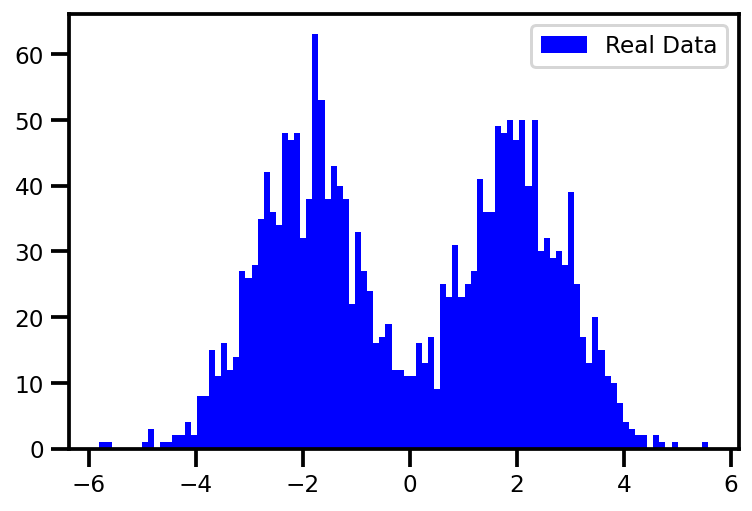

In [ ]:
X_samples = gen_data(2000)

# plot_data(X_samples, color='black');
plot_hist(X_samples, color='blue', label="Real Data")


#### NF Architecture

In [ ]:
n_features = 1

# define invertible transformation
transform = transforms.CompositeTransform(
    [
     # ===========================
     # METHOD 1: spline transform
     # ===========================
     transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
        ),
    # # ================================================================
    # # METHOD 2: Squashing transform + spline transform + unsquashing
    # # ================================================================
    # # Layer 1 - Sigmoid (squashing function)
    # transforms.Sigmoid(),
    # # Layer 2 - Spline CDF Transform 
    # transforms.PiecewiseRationalQuadraticCDF(
    #     shape=[n_features], num_bins=10, tails="linear", tail_bound=1.
    #     ),
    # # Layer 3 - Inverse CDF Function 
    # transforms.Logit(),
    # # =================================
    # # METHOD 2.1: convenience function
    # # =================================
    # transforms.CompositeCDFTransform(
    #     transforms.Sigmoid(),
    #     transforms.PiecewiseRationalQuadraticCDF(shape=[1], num_bins=10)
    #     )
])

# define base distribution
base_distribution = distributions.StandardNormal(shape=[1])

# combine to make a flow
nf_model = flows.Flow(transform=transform, distribution=base_distribution)


In [ ]:
with torch.no_grad():
    z = nf_model.transform_to_noise(torch.Tensor(X_samples))
z.min(), z.max()

(tensor(-5.8014), tensor(5.5716))

In [ ]:
X_samples = torch.Tensor(gen_data(3000))

In [ ]:
X_samples.min(), X_samples.max()

(tensor(-5.2439), tensor(4.7920))

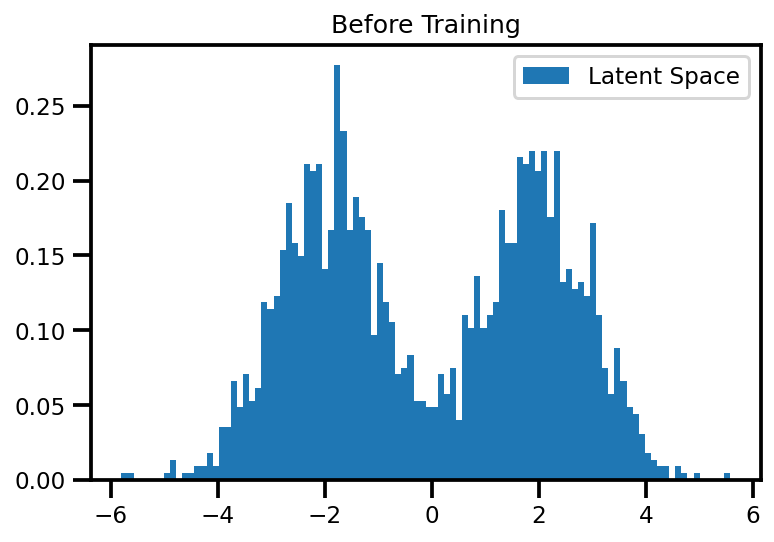

In [ ]:

plt.figure()
plt.hist(z.detach().numpy(), bins=100, density=True, label='Latent Space');
plt.title('Before Training')
plt.legend()
plt.show()

## Training

#### NFlow Trainer 

Just for Convenience for the boilerplate code

In [ ]:
class NFLearner(pl.LightningModule):
    def __init__(self, model, hparams):
        super().__init__()
        self.model = flows.Flow(transform=transform, base_distribution=base_dist)
        self.hparams = hparams

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # self.model.train()
        # self.likelihood.train()
        x, = batch

        # loss function: negative log-likelihood
        loss = -self.model.log_prob(inputs=x).mean()

        # log loss function
        self.log('loss', loss)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam([
            {'params': self.model.parameters()},
        ], lr=self.hparams["lr"])

    # def train_dataloader(self):
    #     return train_loader

    # def val_dataloader(self):
    #     return val_loader

#### Training

In [ ]:
X_data = torch.Tensor(X_samples)
X_data = X_data.to(device)
train_dataset = TensorDataset(X_data)
# val_dataset = TensorDataset(X_val)
batchsize = 100
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

In [ ]:
params = {"lr": 0.1}

In [ ]:

nflow_pl = NFLearner(nf_model.to(device), params)

trainer = Trainer(max_epochs=200, gpus=0)
trainer.fit(nflow_pl, train_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False


2020-11-29 17:20:38,315:INFO:GPU available: False, used: False


TPU available: False, using: 0 TPU cores


2020-11-29 17:20:38,317:INFO:TPU available: False, using: 0 TPU cores



  | Name  | Type | Params
-------------------------------
0 | model | Flow | 29    


2020-11-29 17:20:40,380:INFO:
  | Name  | Type | Params
-------------------------------
0 | model | Flow | 29    


1

#### Latent Space

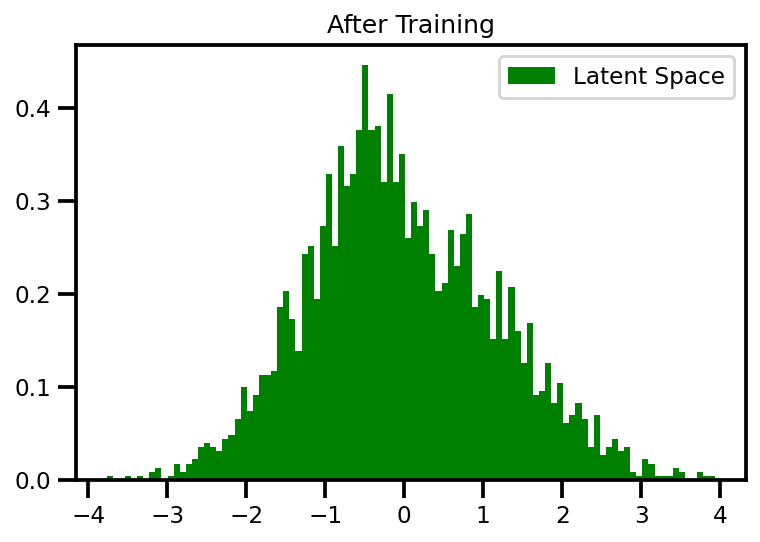

In [ ]:
with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)

plt.figure()
plt.hist(z.numpy(), bins=100, color='green', density=True, label='Latent Space');
plt.title('After Training')
plt.legend()
plt.show()

#### Sampling

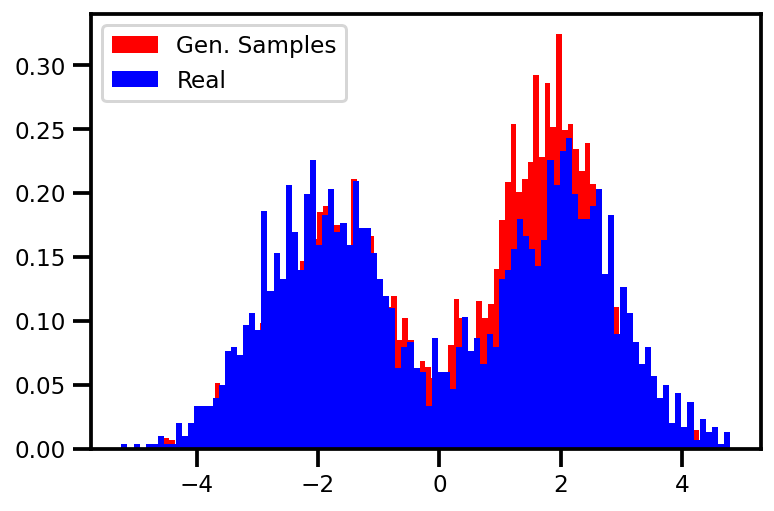

In [ ]:
with torch.no_grad():
    X_approx = nflow_pl.model.sample(5_000)

plt.figure()
plt.hist(X_approx.detach().numpy(), bins=100, color='red', label='Gen. Samples', density=True);
plt.hist(X_samples.detach().numpy(), bins=100, color='blue', label='Real', density=True);
plt.legend()
plt.show()

## 2D Example

In [ ]:
 from sklearn.utils import check_random_state
 def rbig_data(n_samples, noise=0.05,seed=123):
    rng = check_random_state(seed)
    X = np.abs(2 * rng.randn(n_samples, 1))
    Y = np.sin(X) + noise * rng.randn(n_samples, 1)
    data = np.hstack((X, Y))
    return data

def plot_2d_joint(data, color='blue', kind="kde", title='Original Data', **kwargs):
    
    fig  = plt.figure(figsize=(5, 5))

    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color, **kwargs)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

2020-11-29 17:22:29,969:INFO:NumExpr defaulting to 2 threads.


<Figure size 360x360 with 0 Axes>

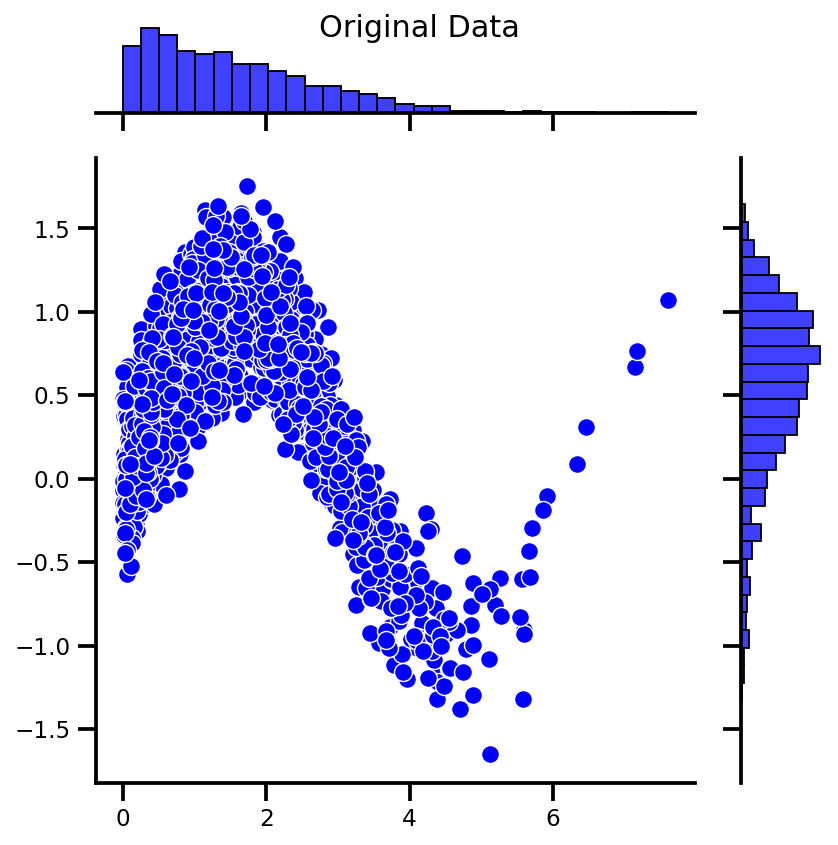

In [ ]:
X_data = rbig_data(2_000, noise=0.25)

dims = X_samples.shape[1]


# print(X_samples.shape)
plot_2d_joint(X_data, kind='scatter', title="Original Data")

In [ ]:
n_features = 2 

# define invertible transformation
transform = transforms.CompositeTransform(
    [
     # ===========================
     # METHOD 1: spline transform
     # ===========================
     transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
        ),
    # # =================================
    # # METHOD 2.1: convenience function
    # # =================================
    # transforms.CompositeCDFTransform(
    #     transforms.Sigmoid(),
    #     transforms.PiecewiseRationalQuadraticCDF(shape=[1], num_bins=10)
    #     )
    ]
    )

# define base distribution
base_distribution = distributions.StandardNormal(shape=[n_features])

# combine to make a flow
nf_model = flows.Flow(transform=transform, distribution=base_distribution)


In [ ]:
X_samples = torch.Tensor(X_data)

train_dataset = TensorDataset(torch.Tensor(X_samples))
# val_dataset = TensorDataset(X_val)
batchsize = 100
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

In [ ]:
nflow_pl = NFLearner(nf_model, params)
trainer = Trainer(max_epochs=100, gpus=0)
trainer.fit(nflow_pl, train_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False


2020-11-29 17:22:31,149:INFO:GPU available: False, used: False


TPU available: False, using: 0 TPU cores


2020-11-29 17:22:31,151:INFO:TPU available: False, using: 0 TPU cores



  | Name  | Type | Params
-------------------------------
0 | model | Flow | 58    


2020-11-29 17:22:31,170:INFO:
  | Name  | Type | Params
-------------------------------
0 | model | Flow | 58    


1

#### Latent Space

<Figure size 360x360 with 0 Axes>

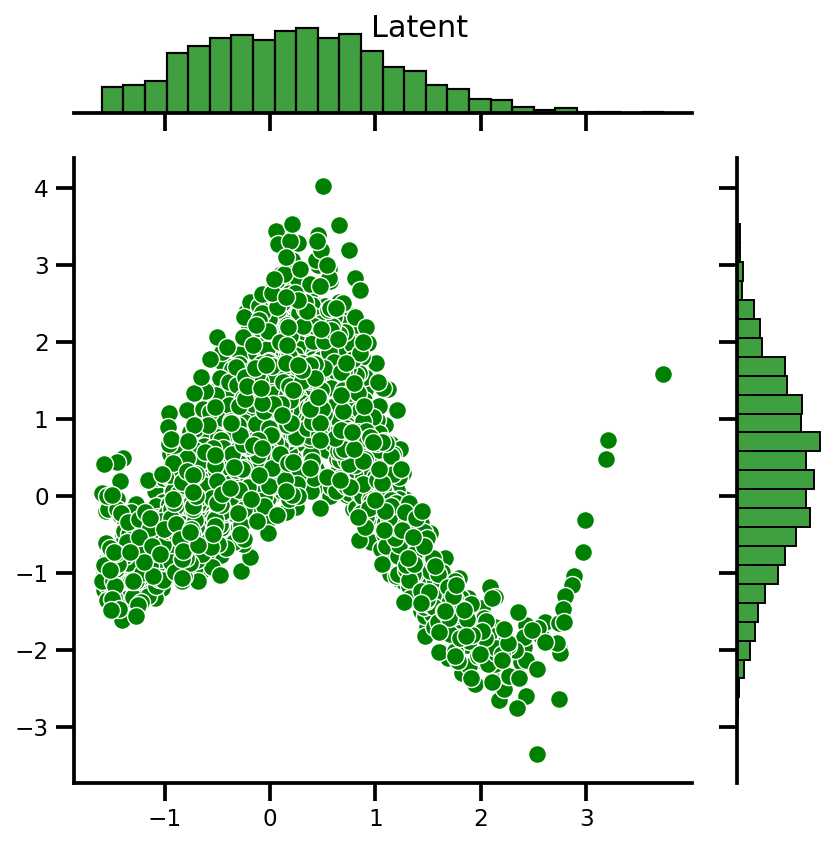

In [ ]:
with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)

plot_2d_joint(z.numpy(), title='Latent', color='green', kind='scatter')

#### Sampling

<Figure size 360x360 with 0 Axes>

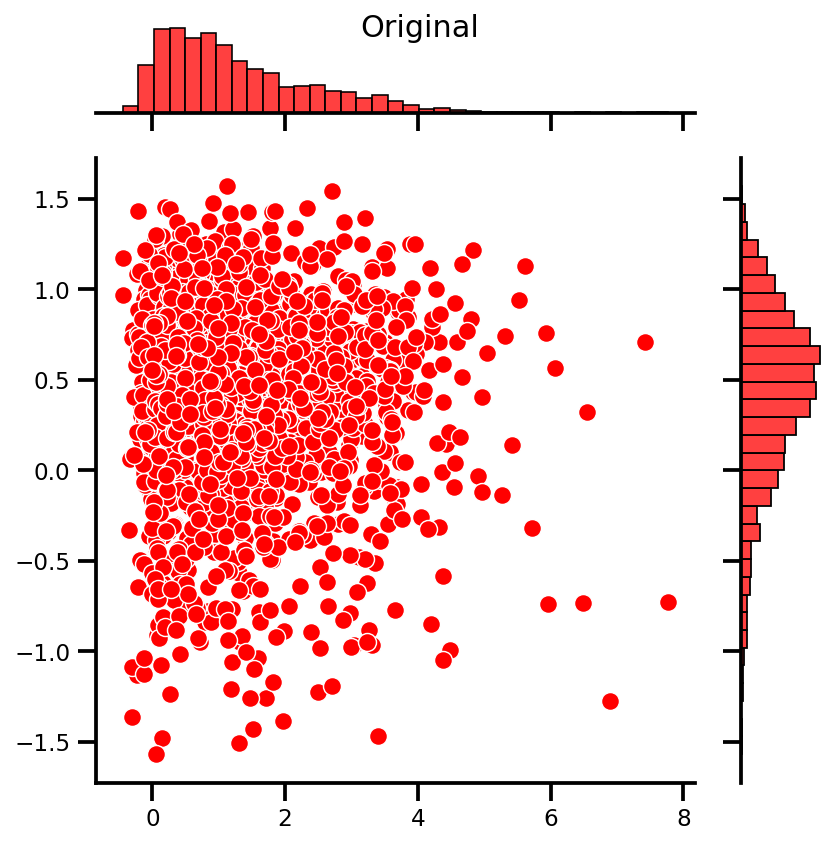

In [ ]:
with torch.no_grad():
    X_approx = nflow_pl.model.sample(2_000)

plot_2d_joint(X_approx.numpy(), title='Original', color='red', kind='scatter')

## 2D + Nonlinearity

Here, we're going to add a non-linearity to our transformation to allow for correlations between dimensions. We can do this by a parameterized orthogonal transformation via Householders.

<Figure size 360x360 with 0 Axes>

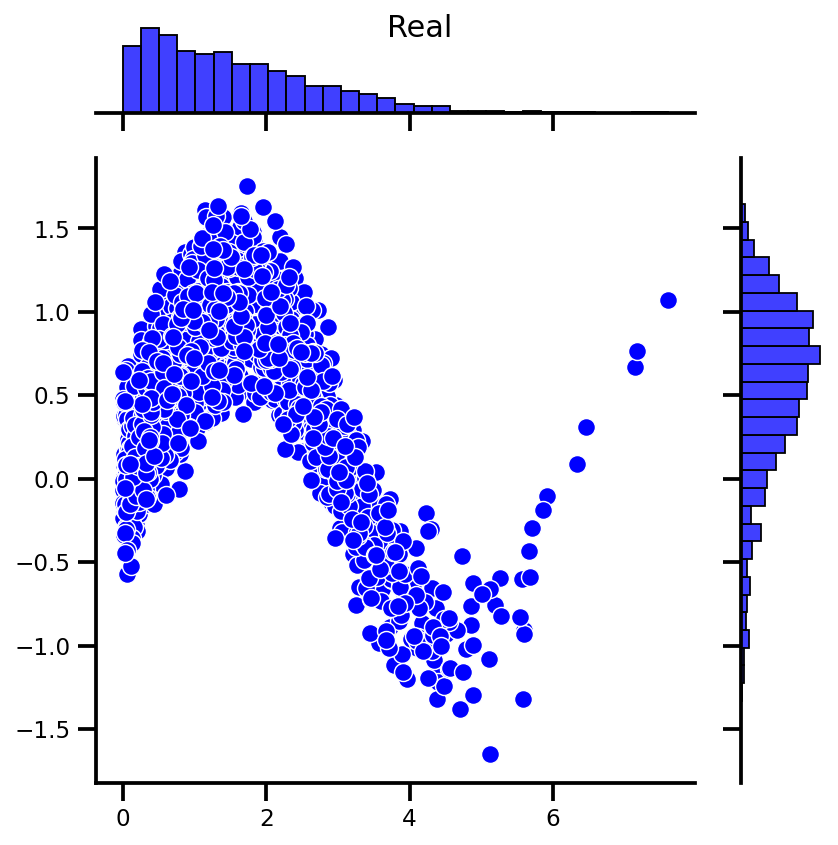

In [ ]:
X_data = rbig_data(2_000, noise=0.25)

plot_2d_joint(X_data, title="Real", color='blue', kind='scatter')

#### Random Permutations

In [ ]:
n_features = 2 

# # define invertible transformation
# # ==========
# # METHOD A: Squashing Transforms
# # ==========
# transform = transforms.CompositeTransform([
#     # Layer 0                                     
#     transforms.HouseholderSequence(features=n_features, num_transforms=2),
#     # Layer 1  
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.HouseholderSequence(features=n_features, num_transforms=2),
#     # Layer 1  
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.HouseholderSequence(features=n_features, num_transforms=2),
#     # Layer 2   
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.HouseholderSequence(features=n_features, num_transforms=2),
#     # Layer 3
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.HouseholderSequence(features=n_features, num_transforms=2),
# ])
# ==========
# METHOD B: Spline + Linear Tails
# ==========
transform = transforms.CompositeTransform([
    # Layer 0                                     
    transforms.HouseholderSequence(features=n_features, num_transforms=2),
    # Layer 1  
    transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    ),
    transforms.HouseholderSequence(features=n_features, num_transforms=2),
    # Layer 1  
    transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    ),
    transforms.HouseholderSequence(features=n_features, num_transforms=2),
    # Layer 2   
    transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    ),
    transforms.HouseholderSequence(features=n_features, num_transforms=2),
    # # Layer 3
    # transforms.PiecewiseRationalQuadraticCDF(
    #     shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    # ),
    # transforms.HouseholderSequence(features=n_features, num_transforms=2),
])

# define base distribution
base_distribution = distributions.StandardNormal(shape=[n_features])



# combine to make a flow
nf_model = flows.Flow(transform=transform, distribution=base_distribution)

# combine to make a flow
nflow_pl = NFLearner(nf_model, {"lr": 0.01})

#### Initial Latent Space

torch.Size([2000, 2])
tensor(-1.6504) tensor(7.6028) torch.Size([2000, 2])


<Figure size 360x360 with 0 Axes>

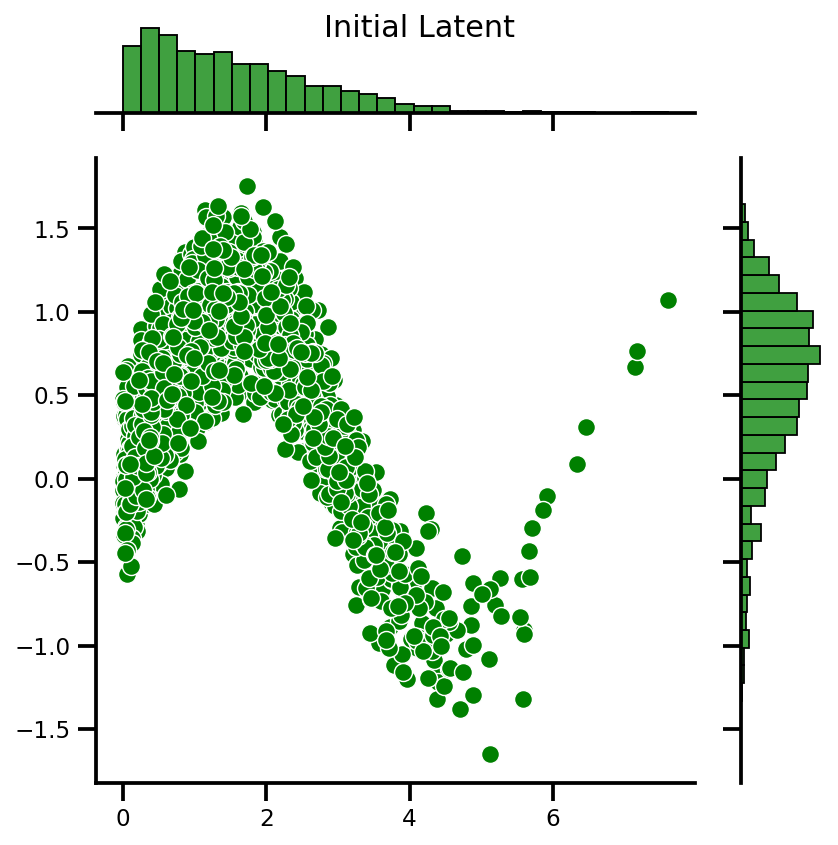

In [ ]:
X_data = rbig_data(2_000, noise=0.25)
X_samples = torch.Tensor(X_data)

with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)
print(z.shape)
print(z.min(), z.max(), z.shape)

plot_2d_joint(z.numpy(), title="Initial Latent", color='green', kind='scatter')

#### Training

In [ ]:
train_dataset = TensorDataset(torch.Tensor(X_samples))
# val_dataset = TensorDataset(X_val)
batchsize = 100
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

In [ ]:
trainer = Trainer(max_epochs=200, gpus=0)
trainer.fit(nflow_pl, train_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False


2020-11-29 17:23:14,243:INFO:GPU available: False, used: False


TPU available: False, using: 0 TPU cores


2020-11-29 17:23:14,249:INFO:TPU available: False, using: 0 TPU cores



  | Name  | Type | Params
-------------------------------
0 | model | Flow | 190   


2020-11-29 17:23:14,263:INFO:
  | Name  | Type | Params
-------------------------------
0 | model | Flow | 190   


1

<Figure size 360x360 with 0 Axes>

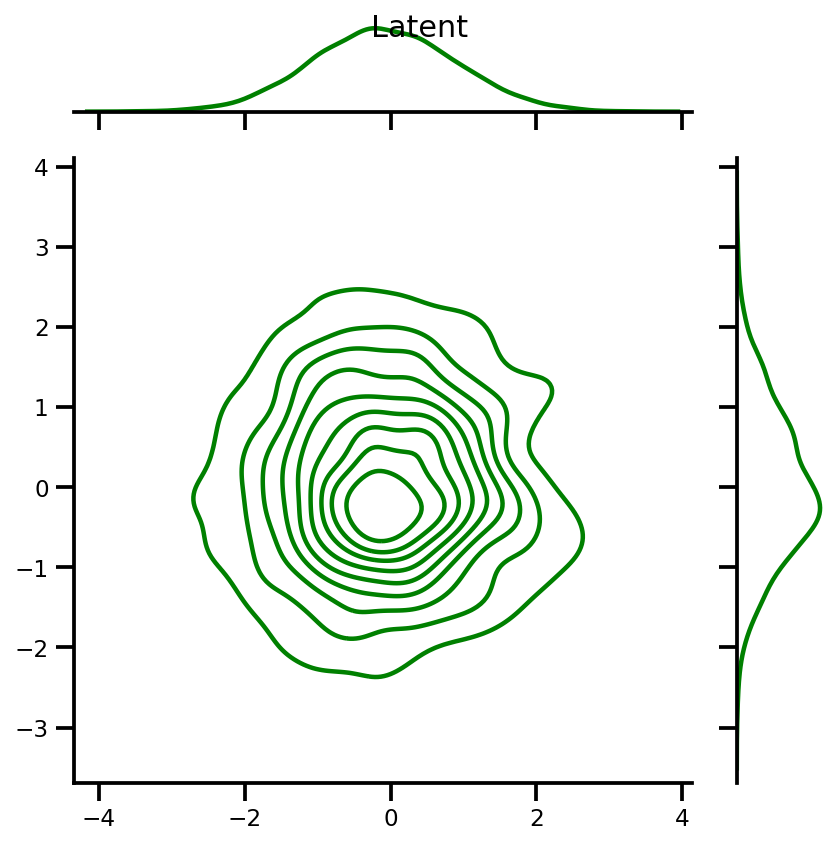

In [ ]:
with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)

plot_2d_joint(z.numpy(), title='Latent', color='green', kind='kde')

<Figure size 360x360 with 0 Axes>

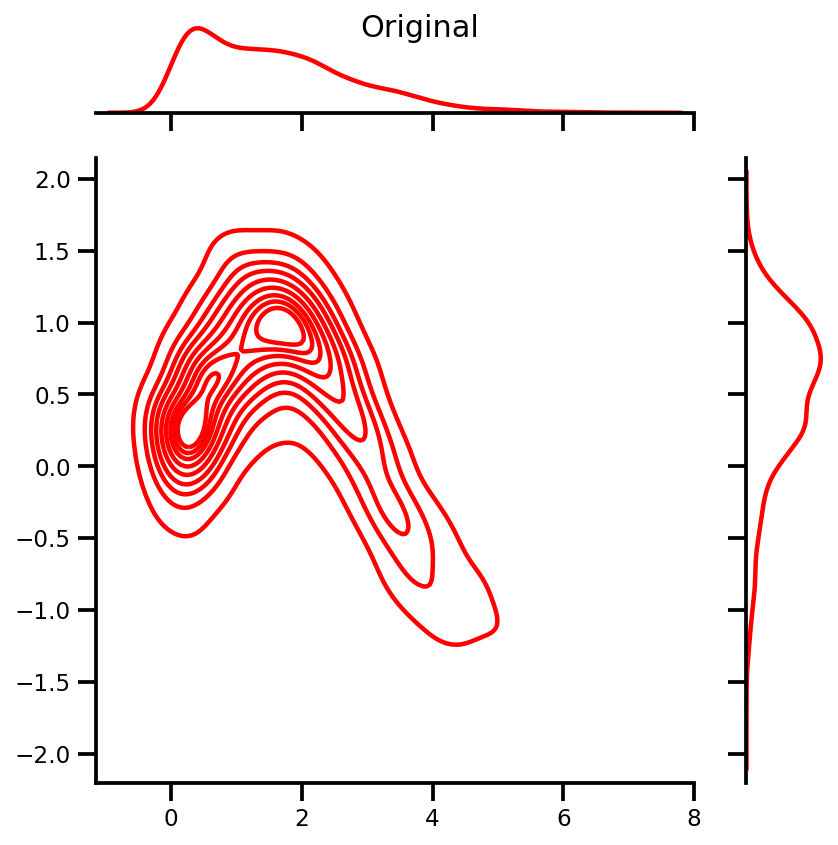

<Figure size 360x360 with 0 Axes>

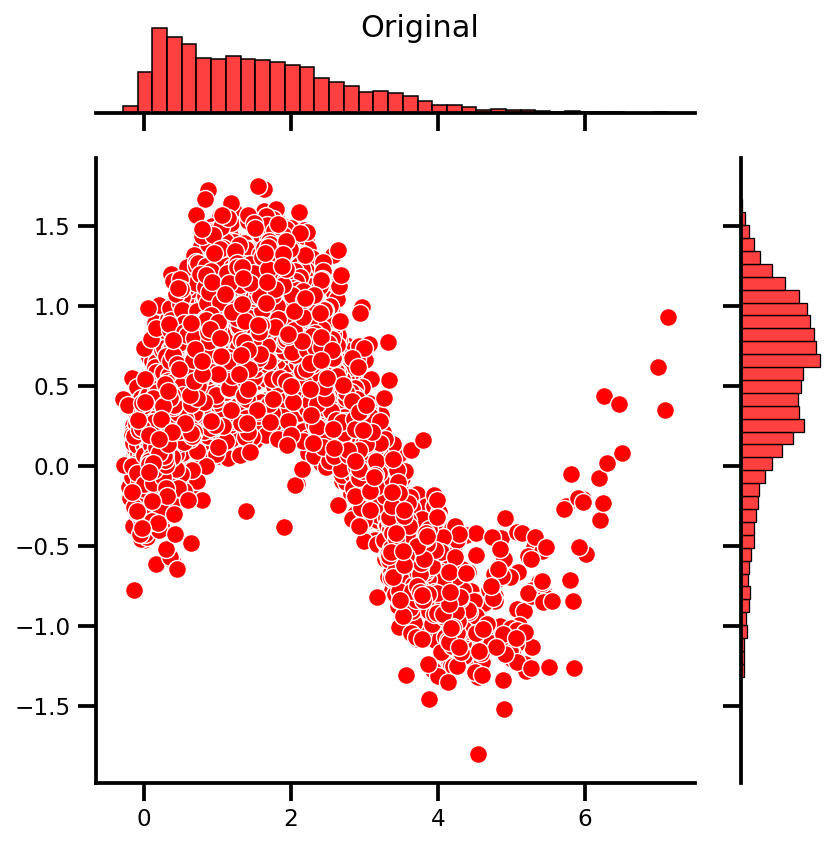

In [ ]:
X_approx = nflow_pl.model.sample(5_000)

plot_2d_joint(X_approx.detach().numpy(), title='Original', color='red', kind='kde')
plot_2d_joint(X_approx.detach().numpy(), title='Original', color='red', kind='scatter')

<Figure size 360x360 with 0 Axes>

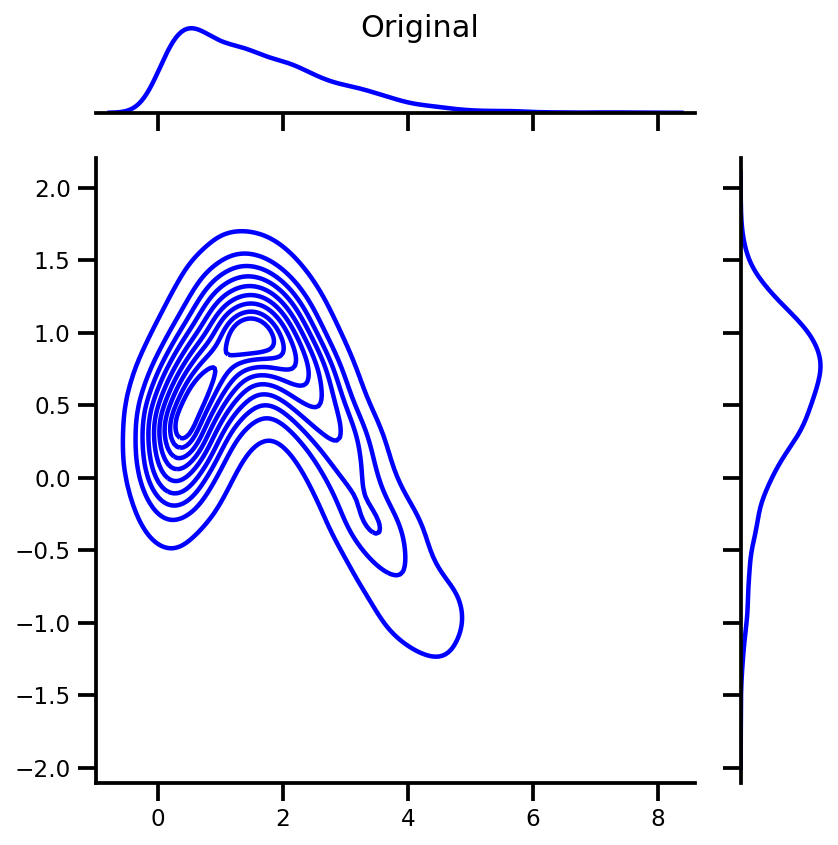

<Figure size 360x360 with 0 Axes>

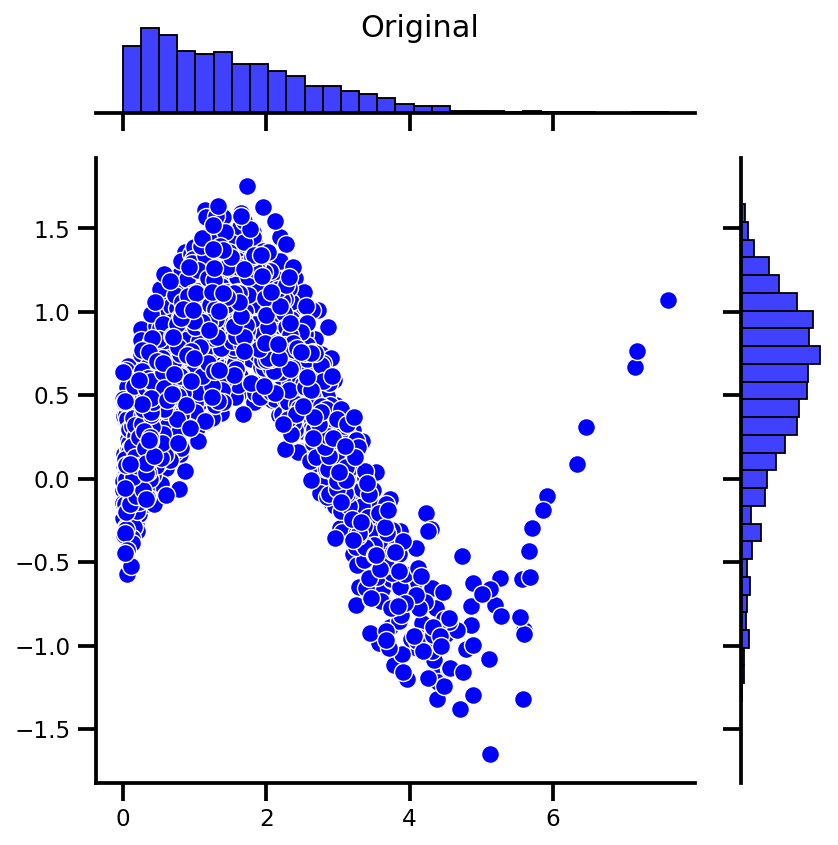

In [ ]:
plot_2d_joint(X_data, title='Original', color='blue', kind='kde')
plot_2d_joint(X_data, title='Original', color='blue', kind='scatter')

#### Probabilities

In [ ]:
# Calculate log probability of samples
with torch.no_grad():
    X_logprob = nflow_pl.model.log_prob(X_samples)

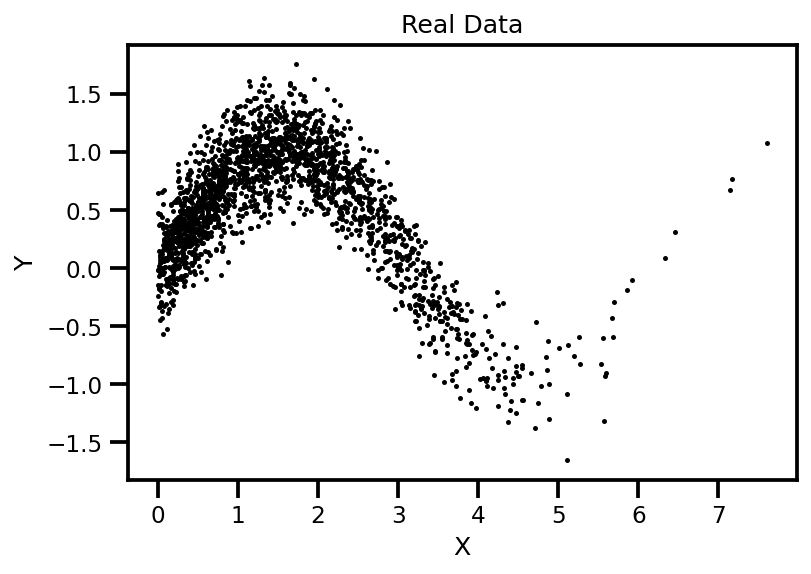

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(X_data[:, 0], X_data[:, 1],
               s=1, c="black")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Real Data')
# plt.colorbar(g)
plt.show()

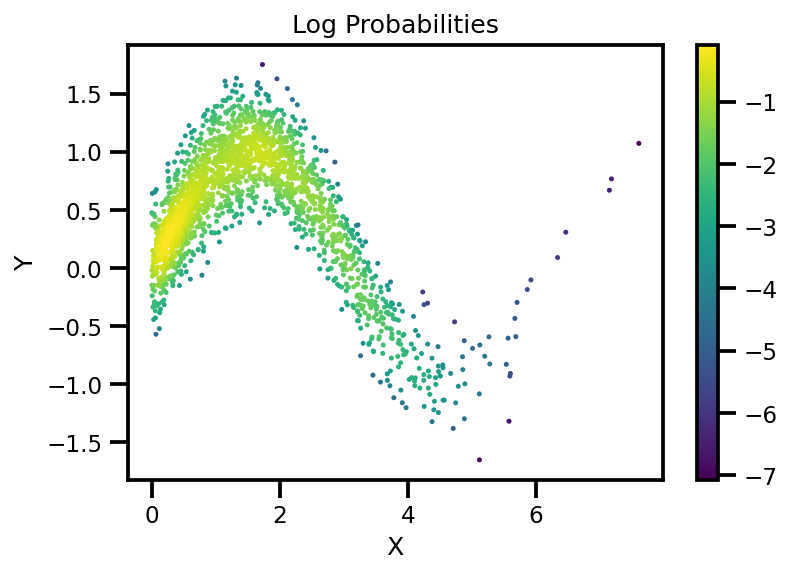

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(X_data[:, 0], X_data[:, 1],
               s=1, c=X_logprob.numpy())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Log Probabilities')
plt.colorbar(g)
plt.show()

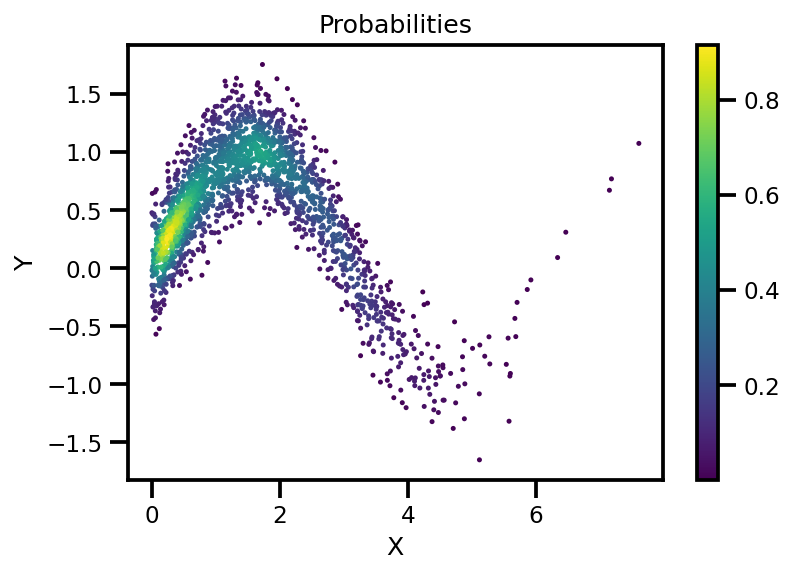

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(X_data[:, 0], X_data[:, 1],
               s=1, c=X_logprob.exp().numpy())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Probabilities')
plt.colorbar(g)
plt.show()

### SVD

In [ ]:
n_features = 2 

# define invertible transformation

# # =================================
# # METHOD A: Squashing Transform
# # =================================
# transform = transforms.CompositeTransform([
#     # Layer 0                                      
#     transforms.SVDLinear(n_features, 2),
#     # Layer 1
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.SVDLinear(n_features, 2),
#     # Layer 2
#     transforms.CompositeCDFTransform(
#         transforms.Sigmoid(),
#         transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#         ),
#     transforms.SVDLinear(n_features, 2),
#     # # Layer 3
#     # transforms.CompositeCDFTransform(
#     #     transforms.Sigmoid(),
#     #     transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
#     #     ),
#     # transforms.SVDLinear(n_features, 2),
# ])
# =================================
# METHOD B: Full Transform
# =================================
transform = transforms.CompositeTransform([
    # Layer 0                                      
    transforms.SVDLinear(n_features, 2),
    # Layer 1
    transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    ),
    transforms.SVDLinear(n_features, 2),
    # Layer 2
    transforms.PiecewiseRationalQuadraticCDF(
        shape=[n_features], num_bins=10, tails="linear", tail_bound=10., identity_init=True
    ),
    transforms.SVDLinear(n_features, 2),
    # # Layer 3
    # transforms.CompositeCDFTransform(
    #     transforms.Sigmoid(),
    #     transforms.PiecewiseRationalQuadraticCDF(shape=[n_features], num_bins=10)
    #     ),
    # transforms.SVDLinear(n_features, 2),
])
# define base distribution
base_distribution = distributions.StandardNormal(shape=[n_features])



# combine to make a flow
nf_model = flows.Flow(transform=transform, distribution=base_distribution)

# combine to make a flow
nflow_pl = NFLearner(nf_model, {"lr": 0.01})

#### Initial Latent Space

torch.Size([2000, 2])
tensor(-1.6504) tensor(7.6028) torch.Size([2000, 2])


<Figure size 360x360 with 0 Axes>

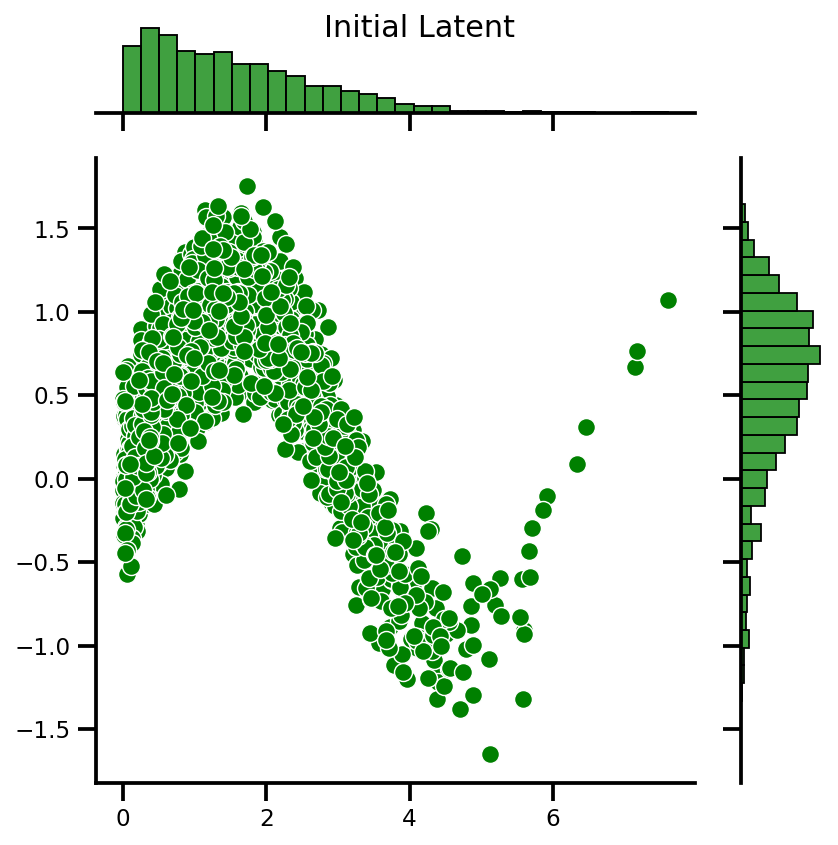

In [ ]:
X_data = rbig_data(2_000, noise=0.25)
X_samples = torch.Tensor(X_data)

with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)
print(z.shape)
print(z.min(), z.max(), z.shape)

plot_2d_joint(z.numpy(), title="Initial Latent", color='green', kind='scatter')

#### Training


In [ ]:
train_dataset = TensorDataset(torch.Tensor(X_samples))
# val_dataset = TensorDataset(X_val)
batchsize = 100
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

trainer = Trainer(max_epochs=200, gpus=0)
trainer.fit(nflow_pl, train_loader)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False


2020-11-29 17:25:41,784:INFO:GPU available: False, used: False


TPU available: False, using: 0 TPU cores


2020-11-29 17:25:41,786:INFO:TPU available: False, using: 0 TPU cores



  | Name  | Type | Params
-------------------------------
0 | model | Flow | 152   


2020-11-29 17:25:41,802:INFO:
  | Name  | Type | Params
-------------------------------
0 | model | Flow | 152   


1

#### Latent Space

<Figure size 360x360 with 0 Axes>

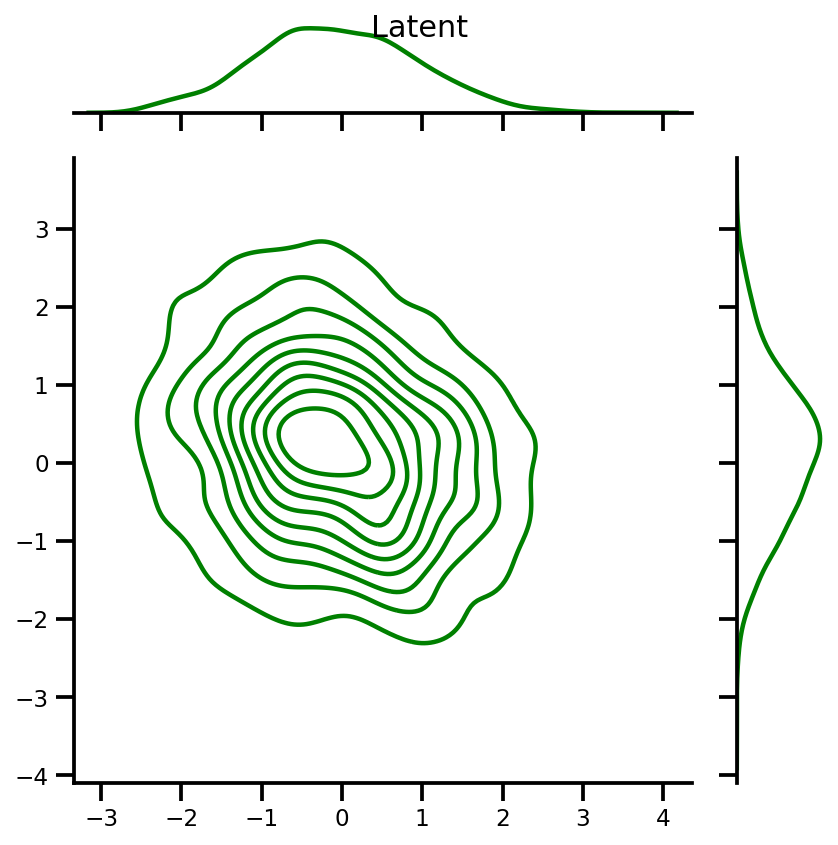

In [ ]:
with torch.no_grad():
    z = nflow_pl.model.transform_to_noise(X_samples)

plot_2d_joint(z.numpy(), title='Latent', color='green', kind='kde')

#### Sampling

In [ ]:
X_approx = nflow_pl.model.sample(10_000)

plot_2d_joint(X_approx.detach().numpy(), title='Original', color='red', kind='kde')

In [ ]:
plot_2d_joint(X_data, title='Original', color='blue', kind='kde')

#### Probabilities

In [ ]:
# Calculate log probability of samples
with torch.no_grad():
    X_logprob = nflow_pl.model.log_prob(X_samples)

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(X_data[:, 0], X_data[:, 1],
               s=1, c=X_logprob.numpy())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Log Probabilities')
plt.colorbar(g)
plt.show()

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(X_data[:, 0], X_data[:, 1],
               s=1, c=X_logprob.exp().numpy())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Probabilities')
plt.colorbar(g)
plt.show()